In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
from sklearn.preprocessing import StandardScaler

In [3]:
# load the dataframe from the pickle file
import pickle
dir = "C:/Users/gusta/OneDrive/Skrivebord/KI & Data/Bachelor/LegeData"
with open(f"{dir}/dataframe.pkl", "rb") as f:
    df = pickle.load(f)

# keep these channels only, these are the indexes: 
""" 
Fp1 -> 0
Fp2 -> 33
F3  -> 4
F4  -> 38
C3  -> 12
C4  -> 48
P3  -> 20
P4  -> 55
O1  -> 26
O2  -> 61
F7  -> 6
F8  -> 40
T7  -> 14
T8  -> 50
P7  -> 22
P8  -> 57
Fz  -> 36
Cz  -> 46
Pz  -> 30 

but add 1 to each index, since the first channel is channel_1
"""

df = df[["channel_1", "channel_34", "channel_5", "channel_39", "channel_13", "channel_49", "channel_21", "channel_56", "channel_27", "channel_62", "channel_7", "channel_41", "channel_15", "channel_51", "channel_23", "channel_58", "channel_37", "channel_47", "channel_31", "label"]]

patient_ids = np.repeat([1,2,3,4,5,6,7,8,9,10],76288)  # Make sure to have this aligned with your epochs/labels

# Normalize per patient (within training and test sets)
data = df.drop("label", axis=1).values
data_norm = []
for patient_id in np.unique(patient_ids):
    patient_data = data[patient_ids == patient_id]
    scaler = StandardScaler()
    patient_data_scaled = scaler.fit_transform(patient_data)
    print(f"mean of patient {patient_id}: {np.min(patient_data_scaled), np.max(patient_data_scaled)}")
    data_norm.append(patient_data_scaled)

data_norm = np.concatenate(data_norm, axis=0)
# add labels back
y = df["label"].values
data = data_norm

# make data a dataframe again
df = pd.DataFrame(data)
print(f"size of df: {df.shape}")

# split the data into epochs of 256 datapoints each
epochs = []
for i in range(0, len(df), 256):
    epochs.append(df.iloc[i:i+256].values)

# convert the list of epochs to a numpy array
epochs = np.array(epochs)
print(f"size of epochs: {epochs.shape}")

# save the SCALED epochs
with open(f"{dir}/scaled_rawEEG_epochs.pkl", "wb") as f:
    pickle.dump(epochs, f)




mean of patient 1: (np.float64(-2.5061664365916747), np.float64(3.2048110636610154))
mean of patient 2: (np.float64(-2.2856199344616766), np.float64(3.1704214250154332))
mean of patient 3: (np.float64(-2.6244058798465795), np.float64(2.326236025125405))
mean of patient 4: (np.float64(-2.9839669159521462), np.float64(3.0033738566092985))
mean of patient 5: (np.float64(-2.7180645928577865), np.float64(1.9617189652654394))
mean of patient 6: (np.float64(-3.8235823428136357), np.float64(1.5538075585523163))
mean of patient 7: (np.float64(-2.17836904765987), np.float64(2.700097334829556))
mean of patient 8: (np.float64(-1.9391087092804788), np.float64(4.868952462591622))
mean of patient 9: (np.float64(-3.278040789072896), np.float64(2.18437991679923))
mean of patient 10: (np.float64(-1.6112388744411374), np.float64(4.696875071895533))
size of df: (762880, 19)
size of epochs: (2980, 256, 19)


In [2]:
labels = []
for _ in range(10):
    labels.append(np.repeat([1, 0], 149))
labels = np.concatenate(labels)

print(f"size of labels: {labels.shape}")


size of labels: (2980,)


In [ ]:


class EEGNet(nn.Module):
    def __init__(self):
        super(EEGNet, self).__init__()
        self.T = sample_len
        self.dropout_rate = 0.1
        
        # Layer 1
        self.conv1 = nn.Conv2d(1, 16, (1, channels), padding = 0)
        self.batchnorm1 = nn.BatchNorm2d(16, False)
        
        # Layer 2
        self.padding1 = nn.ZeroPad2d((16, 17, 0, 1))
        self.conv2 = nn.Conv2d(1, 4, (2, 32))
        self.batchnorm2 = nn.BatchNorm2d(4, False)
        self.pooling2 = nn.MaxPool2d(2, 4)
        
        # Layer 3
        self.padding2 = nn.ZeroPad2d((2, 1, 4, 3))
        self.conv3 = nn.Conv2d(4, 4, (8, 4))
        self.batchnorm3 = nn.BatchNorm2d(4, False)
        self.pooling3 = nn.MaxPool2d((2, 4))
        
        # FC Layer
        # NOTE: This dimension will depend on the number of timestamps per sample in your data.
        # I have 120 timepoints. 
        self.fc1 = nn.Linear(8*2 * (sample_len // 32), 1)
        

    def forward(self, x):
        # Layer 1
        x = F.elu(self.conv1(x))
        x = self.batchnorm1(x)
        x = F.dropout(x, self.dropout_rate)
        x = x.permute(0, 3, 1, 2)
        
        # Layer 2
        x = self.padding1(x)
        x = F.elu(self.conv2(x))
        x = self.batchnorm2(x)
        x = F.dropout(x, self.dropout_rate)
        x = self.pooling2(x)
        
        # Layer 3
        x = self.padding2(x)
        x = F.elu(self.conv3(x))
        x = self.batchnorm3(x)
        x = F.dropout(x, self.dropout_rate)
        x = self.pooling3(x)
        
        # FC Layer
        x = x.reshape(-1, 128)
        x = F.sigmoid(self.fc1(x))
        return x



In [13]:
class EEGNetModel(nn.Module):  # EEGNET-8,2
    def __init__(self, chans=19, classes=1, time_points=256, temp_kernel=128,
                 f1=8, f2=16, d=2, pk1=4, pk2=4, dropout_rate=0.25, max_norm1=1, max_norm2=0.25):
        super(EEGNetModel, self).__init__()


        # Temporal Filters
        self.block1 = nn.Sequential(
            nn.Conv2d(1, f1, (1, temp_kernel), padding='same', bias=False),  # Temporal Conv
            nn.BatchNorm2d(f1),
        )
        # Spatial Filters
        self.block2 = nn.Sequential(
            nn.Conv2d(f1, d * f1, (chans, 1), groups=f1, bias=False),  # Depthwise Conv
            nn.BatchNorm2d(d * f1),
            nn.ELU(),
            nn.AvgPool2d((1, pk1)),  # Pool over time dimension
            nn.Dropout(dropout_rate)
        )
        # Separable Convolution
        self.block3 = nn.Sequential(
            nn.Conv2d(d * f1, f2, (1, 16), padding='same', bias=False, groups=f2),  # Separable Conv
            nn.Conv2d(f2, f2, kernel_size=1, bias=False),  # Pointwise Conv
            nn.BatchNorm2d(f2),
            nn.ELU(),
            nn.AvgPool2d((1, pk2)),  # Pool over time dimension
            nn.Dropout(dropout_rate)
        )
        

        # Fully Connected
        self.fc = nn.Linear(16 * ( time_points // 16 ), classes)

        # Apply max_norm constraint to the depthwise layer in block2
        self._apply_max_norm(self.block2[0], max_norm1)

    def _apply_max_norm(self, layer, max_norm):
        for name, param in layer.named_parameters():
            if 'weight' in name:
                param.data = torch.renorm(param.data, p=2, dim=0, maxnorm=max_norm)

    def forward(self, x):
        # Input x is (batch_size,1, num_channels, num_timepoints)

        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = torch.sigmoid(x)
        return x


# Adjust input size to (19x256)
sample_len = 256  # Your time points
channels = 19     # Your number of channels

# summary
from torchsummary import summary

model = EEGNetModel(chans=channels, time_points=sample_len)
summary(model, (1, 19, 256))


print(model.forward(Variable(torch.Tensor(16, 1, 19, 256))))
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# apply Xavier weight initialization
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.xavier_uniform(m.weight)
model.apply(init_weights)





----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 8, 19, 256]           1,024
       BatchNorm2d-2           [-1, 8, 19, 256]              16
            Conv2d-3           [-1, 16, 1, 256]             304
       BatchNorm2d-4           [-1, 16, 1, 256]              32
               ELU-5           [-1, 16, 1, 256]               0
         AvgPool2d-6            [-1, 16, 1, 64]               0
           Dropout-7            [-1, 16, 1, 64]               0
            Conv2d-8            [-1, 16, 1, 64]             256
            Conv2d-9            [-1, 16, 1, 64]             256
      BatchNorm2d-10            [-1, 16, 1, 64]              32
              ELU-11            [-1, 16, 1, 64]               0
        AvgPool2d-12            [-1, 16, 1, 16]               0
          Dropout-13            [-1, 16, 1, 16]               0
           Linear-14                   

C:\Users\gusta\AppData\Local\Temp\ipykernel_3352\3272494471.py:73: FutureWarning: `nn.init.xavier_uniform` is now deprecated in favor of `nn.init.xavier_uniform_`.
  torch.nn.init.xavier_uniform(m.weight)


EEGNetModel(
  (block1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(1, 128), stride=(1, 1), padding=same, bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(19, 1), stride=(1, 1), groups=8, bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
    (4): Dropout(p=0.25, inplace=False)
  )
  (block3): Sequential(
    (0): Conv2d(16, 16, kernel_size=(1, 16), stride=(1, 1), padding=same, groups=16, bias=False)
    (1): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ELU(alpha=1.0)
    (4): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
    (5): Dropout(p=0.25, inplace=False)
  )
  (fc): Linear(in_features=256, out_features=

In [5]:
# open the scaled epochs
import pickle
import pandas as pd
dir = "C:/Users/gusta/OneDrive/Skrivebord/KI & Data/Bachelor/LegeData"


with open(f"{dir}/scaled_rawEEG_epochs.pkl", "rb") as f:
    epochs = pickle.load(f)




Evaluate function


In [14]:
import torch
from torch.autograd import Variable
import numpy as np
from sklearn.metrics import accuracy_score

# open the scaled epochs
with open(f"{dir}/scaled_rawEEG_epochs.pkl", "rb") as f:
    epochs = pickle.load(f)

# Define simple evaluation function
def evaluate(model, dataloader, sample_len, channels):
    model.eval()
    model_predictions = []
    true_labels = []

    for _, (data, target) in enumerate(dataloader):

      inputs, targets = data , target
      inputs = inputs.unsqueeze(1)

      data = Variable((inputs))
      target = Variable((targets))
      
      output = model(data).squeeze()

      model_predictions.extend(output.detach().numpy())
      true_labels.extend(target.detach().numpy())

    all_predictions = np.array(model_predictions) > 0.5
    all_targets = np.array(true_labels)



    accuracy = accuracy_score(all_targets, all_predictions)
    return accuracy

In [15]:
from torch.utils.data import DataLoader, Dataset

# Dataset class definition
class EEGDataset(Dataset):
    def __init__(self, epochs, labels):
        self.df = epochs
        self.labels = labels

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Access the epoch and corresponding label
        data = self.df[idx]  # data shape: (256, 19)
        data = data.T  # shape: (19, 256)
        label = self.labels[idx]  # label shape: (1)
        
        # Ensure the data is converted to float tensor
        data_tensor = torch.tensor(data, dtype=torch.float32)
        
        # Convert label to tensor (assumed to be scalar)
        label_tensor = torch.tensor(label, dtype=torch.float32) 
        
        return data_tensor, label_tensor

# Create EEGDataset object and print a batch of 16 samples
dataset = EEGDataset(epochs, labels)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

print(next(iter(dataloader))[0].shape)



torch.Size([16, 19, 256])


# Homemade small CNN 2,033 parameters


In [74]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EEGClassifier(nn.Module):
    def __init__(self, num_channels=19, num_timepoints=256):
        super(EEGClassifier, self).__init__()

        # 1st Conv Layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(1, 64), stride=(1, 1), padding=(0, 32))  # Conv over time
        self.bn1 = nn.BatchNorm2d(16)  # Batch normalization after convolution
        self.pool1 = nn.AvgPool2d(kernel_size=(1, 4))  # Pooling over time dimension
        self.drop1 = nn.Dropout(0.25)  # Dropout after first block

        # 2nd Conv Layer (Depthwise Separable Convolution)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(num_channels, 1), groups=16)  # Depthwise over channels
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.AvgPool2d(kernel_size=(1, 8))
        self.drop2 = nn.Dropout(0.25)

        # Fully Connected Layer for classification (sigmoid for binary classification)
        self.fc = nn.Linear(32 * (num_timepoints // 32), 1)  # Output 1 neuron for binary classification

    def forward(self, x):
        # Input x is (batch_size, num_channels, num_timepoints)
        x = x.unsqueeze(1)  # Add a channel dimension: (batch_size, 1, num_channels, num_timepoints)

        # 1st Conv Block
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = self.drop1(x)

        # 2nd Conv Block
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = self.drop2(x)

        # Flatten for fully connected layer
        x = x.view(x.size(0), -1)

        # Fully Connected Layer with sigmoid activation for binary classification
        x = torch.sigmoid(self.fc(x))
        return x

# Initialize the model
model = EEGClassifier(num_channels=19, num_timepoints=256)

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# explore model size and trainable parameters
from torchsummary import summary
summary(model, (19, 256))




----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 16, 19, 257]           1,040
       BatchNorm2d-2          [-1, 16, 19, 257]              32
         AvgPool2d-3           [-1, 16, 19, 64]               0
           Dropout-4           [-1, 16, 19, 64]               0
            Conv2d-5            [-1, 32, 1, 64]             640
       BatchNorm2d-6            [-1, 32, 1, 64]              64
         AvgPool2d-7             [-1, 32, 1, 8]               0
           Dropout-8             [-1, 32, 1, 8]               0
            Linear-9                    [-1, 1]             257
Total params: 2,033
Trainable params: 2,033
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 1.52
Params size (MB): 0.01
Estimated Total Size (MB): 1.55
-----------------------------------------------

# Slightly bigger CNN 204,737 parameters

In [67]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LargeEEGClassifier(nn.Module):
    def __init__(self, num_channels=19, num_timepoints=256):
        super(LargeEEGClassifier, self).__init__()

        # 1st Conv Layer: more filters and wider kernel
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(1, 64), stride=(1, 1), padding=(0, 32))  # Conv over time
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.AvgPool2d(kernel_size=(1, 4))
        self.drop1 = nn.Dropout(0.25)

        # 2nd Conv Layer: more filters
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(num_channels, 1), groups=64)  # Depthwise over channels
        self.bn2 = nn.BatchNorm2d(128)
        self.pool2 = nn.AvgPool2d(kernel_size=(1, 8))
        self.drop2 = nn.Dropout(0.25)

        # 3rd Conv Layer: additional layer to increase complexity
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(1, 4), padding=(0, 2))
        self.bn3 = nn.BatchNorm2d(256)
        self.pool3 = nn.AvgPool2d(kernel_size=(1, 4))
        self.drop3 = nn.Dropout(0.25)

        # Fully Connected Layer for classification
        self.fc1 = nn.Linear(256 * (num_timepoints // 128), 128)  # First fully connected layer
        self.fc2 = nn.Linear(128, 1)  # Second fully connected layer for binary classification

    def forward(self, x):
        # Input x is (batch_size, num_channels, num_timepoints)
        x = x.unsqueeze(1)  # Add a channel dimension: (batch_size, 1, num_channels, num_timepoints)

        # 1st Conv Block
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = self.drop1(x)

        # 2nd Conv Block
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = self.drop2(x)

        # 3rd Conv Block
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        x = self.drop3(x)

        # Flatten for fully connected layer
        x = x.view(x.size(0), -1)

        # Fully Connected Layers
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))  # Sigmoid for binary classification
        return x

# Initialize the model
model = LargeEEGClassifier(num_channels=19, num_timepoints=256)

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Explore model size and trainable parameters
summary(model, (19, 256))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 64, 19, 257]           4,160
       BatchNorm2d-2          [-1, 64, 19, 257]             128
         AvgPool2d-3           [-1, 64, 19, 64]               0
           Dropout-4           [-1, 64, 19, 64]               0
            Conv2d-5           [-1, 128, 1, 64]           2,560
       BatchNorm2d-6           [-1, 128, 1, 64]             256
         AvgPool2d-7            [-1, 128, 1, 8]               0
           Dropout-8            [-1, 128, 1, 8]               0
            Conv2d-9            [-1, 256, 1, 9]         131,328
      BatchNorm2d-10            [-1, 256, 1, 9]             512
        AvgPool2d-11            [-1, 256, 1, 2]               0
          Dropout-12            [-1, 256, 1, 2]               0
           Linear-13                  [-1, 128]          65,664
           Linear-14                   

#### Training and evaluation loop

In [17]:
from sklearn.model_selection import LeaveOneGroupOut
from tqdm import tqdm
import torch
from torch.autograd import Variable
import numpy as np

# define random seed
torch.manual_seed(42)

batch_size = 16
num_epochs = 50
patience = 20  # Stop if no improvement after 20 epochs
best_val_acc = 0.0  # Track the best validation accuracy
no_improvement_epochs = 0  # Track how many epochs without improvement

# Lists to store loss values for plotting later
train_loss_history = []
val_loss_history = []

# Initialize Leave-One-Group-Out cross-validator
logo = LeaveOneGroupOut()

# Ensure patient_ids has the same length as epochs and labels
patient_ids = np.repeat([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], len(epochs) // 10)  # Adjust the length accordingly

for epoch in tqdm(range(num_epochs)):  # Loop over the number of epochs
    print(f"Epoch {epoch+1}")
    running_loss = []
    running_val_loss = []

    for train_index, test_index in logo.split(epochs, labels, groups=patient_ids):
        # Training loop
        model.train()

        # Train and test split
        X_train, X_val = epochs[train_index, :, :], epochs[test_index, :, :]
        y_train, y_val = labels[train_index], labels[test_index]
        
        # Create DataLoader for training and testing
        train_dataset = EEGDataset(X_train, y_train)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        val_dataset = EEGDataset(X_val, y_val)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        
        # Training
        for i, data in enumerate(train_loader, 0):
            # Get the inputs; data is a list of [inputs, labels/targets]
            inputs, targets = data

            # Convert inputs and targets to variables
            inputs, targets = Variable(inputs), Variable(targets)

            # check if the input shape is correct
            inputs = inputs.unsqueeze(1)  # Add a channel dimension if needed
            # print(f"input shape: {inputs.shape}")

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            targets = targets.unsqueeze(1)  # Ensure targets have the same shape as outputs
            loss = criterion(outputs, targets)
            
            # Backward pass and optimization
            loss.backward()
            # for name, param in model.named_parameters():
            #     if param.grad is not None:
            #         print(f"Gradients for {name}: {param.grad.abs().mean()}")

            optimizer.step()

            running_loss.append(loss.item())

    # Validation Loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, targets in val_loader:
            inputs, targets = Variable(inputs), Variable(targets)
            inputs = inputs.unsqueeze(1)  # Add a channel dimension if needed
            outputs = model(inputs)
            targets = targets.unsqueeze(1)  # Ensure targets have the same shape as outputs
            loss = criterion(outputs, targets)
            running_val_loss.append(loss.item())

            # Calculate validation accuracy
            predicted = (outputs > 0.5).float()
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    
    accuracy = 100 * correct / total
    avg_val_loss = np.mean(running_val_loss)
    
    # Print losses and accuracy for current epoch
    print(f'Epoch {epoch+1}, Validation Accuracy: {accuracy}')
    print(f"Training Loss: {np.mean(running_loss):.4f}, Validation Loss: {avg_val_loss:.4f}")
    
    # Store losses for plotting later
    train_loss_history.append(np.mean(running_loss))
    val_loss_history.append(avg_val_loss)

    # Early Stopping logic
    if accuracy > best_val_acc:
        best_val_acc = accuracy  # Update the best validation accuracy
        no_improvement_epochs = 0  # Reset the counter if there's improvement
        torch.save(model.state_dict(), f"{dir}/EEGNet_model.pth")  # Save the best model
    else:
        no_improvement_epochs += 1

    if no_improvement_epochs >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break  # Exit the training loop


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1


  2%|▏         | 1/50 [00:31<25:51, 31.66s/it]

Epoch 1, Validation Accuracy: 95.63758389261746
Training Loss: 0.4083, Validation Loss: 0.2137
Epoch 2


  4%|▍         | 2/50 [01:01<24:29, 30.61s/it]

Epoch 2, Validation Accuracy: 90.60402684563758
Training Loss: 0.4130, Validation Loss: 0.2407
Epoch 3


  6%|▌         | 3/50 [01:32<23:58, 30.61s/it]

Epoch 3, Validation Accuracy: 99.32885906040268
Training Loss: 0.4000, Validation Loss: 0.1487
Epoch 4


  8%|▊         | 4/50 [02:12<26:19, 34.34s/it]

Epoch 4, Validation Accuracy: 98.99328859060402
Training Loss: 0.3950, Validation Loss: 0.1713
Epoch 5


 10%|█         | 5/50 [02:43<24:56, 33.26s/it]

Epoch 5, Validation Accuracy: 98.65771812080537
Training Loss: 0.3912, Validation Loss: 0.1728
Epoch 6


 12%|█▏        | 6/50 [03:15<23:57, 32.66s/it]

Epoch 6, Validation Accuracy: 100.0
Training Loss: 0.3858, Validation Loss: 0.1599
Epoch 7


 14%|█▍        | 7/50 [03:46<23:07, 32.27s/it]

Epoch 7, Validation Accuracy: 100.0
Training Loss: 0.3820, Validation Loss: 0.1552
Epoch 8


 16%|█▌        | 8/50 [04:19<22:44, 32.49s/it]

Epoch 8, Validation Accuracy: 97.6510067114094
Training Loss: 0.3928, Validation Loss: 0.1874
Epoch 9


 18%|█▊        | 9/50 [04:54<22:40, 33.19s/it]

Epoch 9, Validation Accuracy: 97.6510067114094
Training Loss: 0.3844, Validation Loss: 0.1869
Epoch 10


 20%|██        | 10/50 [05:25<21:42, 32.57s/it]

Epoch 10, Validation Accuracy: 91.94630872483222
Training Loss: 0.3837, Validation Loss: 0.2324
Epoch 11


 22%|██▏       | 11/50 [05:57<21:03, 32.39s/it]

Epoch 11, Validation Accuracy: 95.30201342281879
Training Loss: 0.3764, Validation Loss: 0.2074
Epoch 12


 24%|██▍       | 12/50 [06:33<21:13, 33.52s/it]

Epoch 12, Validation Accuracy: 97.31543624161074
Training Loss: 0.3760, Validation Loss: 0.1934
Epoch 13


 26%|██▌       | 13/50 [07:04<20:14, 32.84s/it]

Epoch 13, Validation Accuracy: 97.98657718120805
Training Loss: 0.3720, Validation Loss: 0.1773
Epoch 14


 28%|██▊       | 14/50 [07:36<19:25, 32.38s/it]

Epoch 14, Validation Accuracy: 96.97986577181209
Training Loss: 0.3784, Validation Loss: 0.1446
Epoch 15


 30%|███       | 15/50 [08:07<18:48, 32.24s/it]

Epoch 15, Validation Accuracy: 99.32885906040268
Training Loss: 0.3791, Validation Loss: 0.1541
Epoch 16


 32%|███▏      | 16/50 [08:42<18:36, 32.85s/it]

Epoch 16, Validation Accuracy: 98.32214765100672
Training Loss: 0.3780, Validation Loss: 0.1637
Epoch 17


 34%|███▍      | 17/50 [09:14<17:56, 32.61s/it]

Epoch 17, Validation Accuracy: 97.98657718120805
Training Loss: 0.3743, Validation Loss: 0.1655
Epoch 18


 36%|███▌      | 18/50 [09:46<17:24, 32.63s/it]

Epoch 18, Validation Accuracy: 100.0
Training Loss: 0.3658, Validation Loss: 0.1379
Epoch 19


 38%|███▊      | 19/50 [10:20<17:04, 33.04s/it]

Epoch 19, Validation Accuracy: 96.64429530201342
Training Loss: 0.3588, Validation Loss: 0.1270
Epoch 20


 40%|████      | 20/50 [10:53<16:26, 32.88s/it]

Epoch 20, Validation Accuracy: 96.64429530201342
Training Loss: 0.3551, Validation Loss: 0.1827
Epoch 21


 42%|████▏     | 21/50 [11:25<15:45, 32.61s/it]

Epoch 21, Validation Accuracy: 86.91275167785236
Training Loss: 0.3528, Validation Loss: 0.2834
Epoch 22


 44%|████▍     | 22/50 [12:05<16:14, 34.81s/it]

Epoch 22, Validation Accuracy: 100.0
Training Loss: 0.3524, Validation Loss: 0.1445
Epoch 23


 46%|████▌     | 23/50 [12:38<15:27, 34.35s/it]

Epoch 23, Validation Accuracy: 100.0
Training Loss: 0.3493, Validation Loss: 0.1331
Epoch 24


 48%|████▊     | 24/50 [13:09<14:28, 33.41s/it]

Epoch 24, Validation Accuracy: 100.0
Training Loss: 0.3502, Validation Loss: 0.1315
Epoch 25


 50%|█████     | 25/50 [13:40<13:36, 32.67s/it]

Epoch 25, Validation Accuracy: 93.95973154362416
Training Loss: 0.3478, Validation Loss: 0.1912
Epoch 26


 50%|█████     | 25/50 [14:12<14:12, 34.09s/it]

Epoch 26, Validation Accuracy: 94.29530201342281
Training Loss: 0.3371, Validation Loss: 0.1291
Early stopping at epoch 26


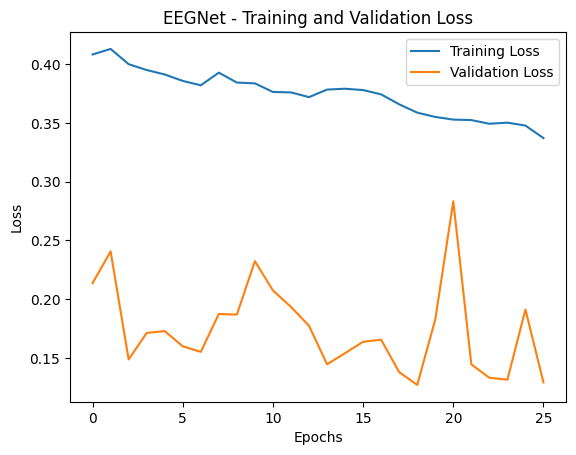

In [18]:
# PLOTTING
import matplotlib.pyplot as plt

plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.title('EEGNet - Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


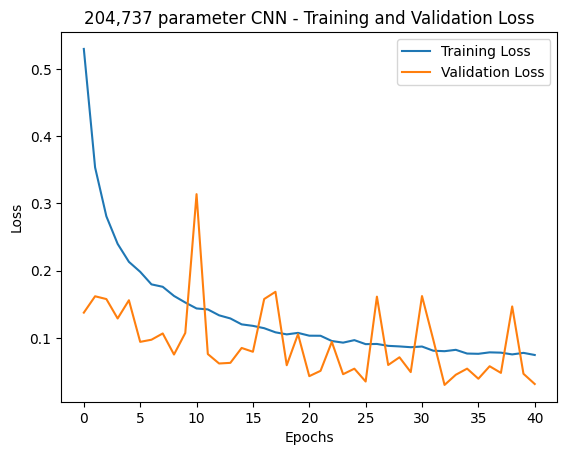

In [73]:
# PLOTTING
import matplotlib.pyplot as plt

plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.title('204,737 parameter CNN - Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()